# 01. Basic Example
A simple example on how to use the FDTD Library

## Imports

In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/bij/Projects/fdtd/')
import fdtd
import fdtd.backend as bd

## Set Backend

In [2]:
fdtd.set_backend("torch")

## Constants

In [3]:
WAVELENGTH = 1550e-9
SPEED_LIGHT: float = 299_792_458.0  # [m/s] speed of light

## Simulation

create FDTD Grid

In [4]:
grid = fdtd.Grid(
    #(8.5e-6, 8.5e-6, 8.5e-6), 
    #(1.5e-5, 1.5e-5, 1.5e-5),
    (3.5e-6, 3.5e-6, 3.5e-6),
    #(1.5e-6, 1.5e-6, 1.5e-6),
    grid_spacing=0.01 * WAVELENGTH,
    permittivity=1.0,
    permeability=1.0,
)
grid.shape

(226, 226, 226)

boundaries

In [5]:
# grid[0, :, :] = fdtd.PeriodicBoundary(name="xbounds")
grid[0:10, :, :] = fdtd.PML(name="pml_xlow")
grid[-10:, :, :] = fdtd.PML(name="pml_xhigh")

# grid[:, 0, :] = fdtd.PeriodicBoundary(name="ybounds")
grid[:, 0:10, :] = fdtd.PML(name="pml_ylow")
grid[:, -10:, :] = fdtd.PML(name="pml_yhigh")

#grid[:, :, 0] = fdtd.PeriodicBoundary(name="zbounds")
grid[:, :, 0:10] = fdtd.PML(name="pml_zlow")
grid[:, :, -10:] = fdtd.PML(name="pml_zhigh")

sources

In [6]:
grid[20, :, :] = fdtd.PlaneSource(
    period=WAVELENGTH / SPEED_LIGHT, name="linesource"
)


detectors

In [7]:
grid[:, grid.shape[1]//2, grid.shape[2]//2] = fdtd.LineDetector(name="detector")

## Run simulation

In [8]:
grid.run(500, progress_bar=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [08:04<00:00,  1.03it/s]


## Visualization

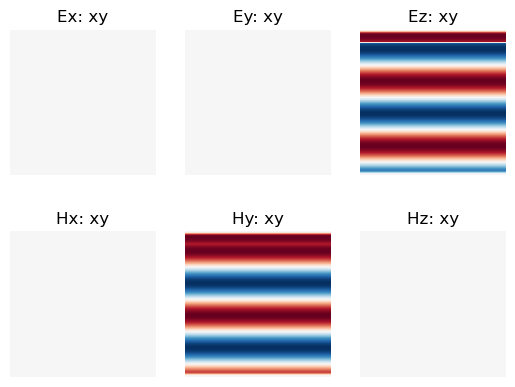

In [9]:
fig, axes = plt.subplots(2, 3, squeeze=False)
titles = ["Ex: xy", "Ey: xy", "Ez: xy", "Hx: xy", "Hy: xy", "Hz: xy"]

fields = bd.stack(
    [
        grid.E[:, :, 0, 0],
        grid.E[:, :, 0, 1],
        grid.E[:, :, 0, 2],
        grid.H[:, :, 0, 0],
        grid.H[:, :, 0, 1],
        grid.H[:, :, 0, 2],
    ]
)

m = max(abs(fields.min().item()), abs(fields.max().item()))

for ax, field, title in zip(axes.ravel(), fields, titles):
    ax.set_axis_off()
    ax.set_title(title)
    ax.imshow(bd.numpy(field), vmin=-m, vmax=m, cmap="RdBu")

plt.show()

Emax:  tensor(1.0000)
Hmax:  tensor(1.0004)


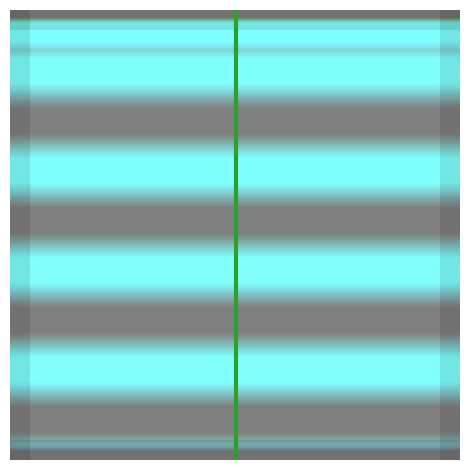

In [10]:
plt.figure()
grid.visualize(z=0)

In [11]:
Hs = bd.stack(grid.detectors[0].H, axis=0)
Es = bd.stack(grid.detectors[0].E, axis=0)
print(Hs.shape, Es.shape)

torch.Size([500, 226, 3]) torch.Size([500, 226, 3])


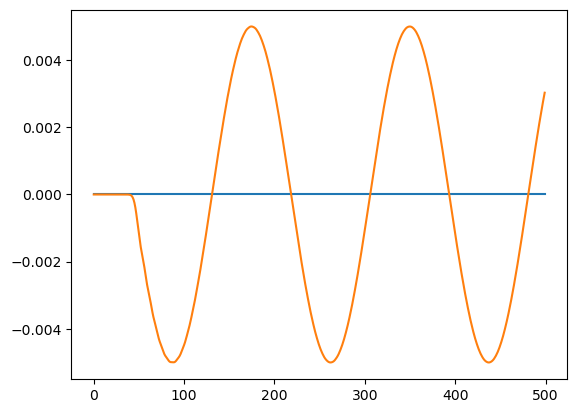

In [12]:
plt.plot(Hs[:, 45, 0])
plt.plot(Es[:, 45, 2]/200)

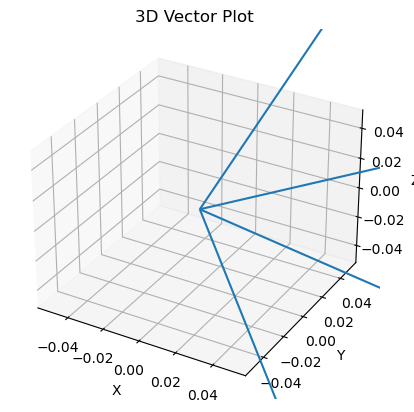

In [13]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# def plot_3d_vectors(vectors):
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')

#     # Extract x, y, z components of each vector
#     x = [v[0] for v in vectors]
#     y = [v[1] for v in vectors]
#     z = [v[2] for v in vectors]

#     # Plot the vectors
#     ax.quiver(0, 0, 0, x, y, z)

#     # Set labels and title
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     ax.set_title('3D Vector Plot')

#     plt.show()

# # Example usage:
# vectors = [
#     [1, 2, 3],
#     [3, 2, 1],
#     [-1, -2, 2],
#     [2, -1, -3]
# ]

# plot_3d_vectors(vectors)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_vectors(vectors, scale=1.0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Normalize vectors
    normalized_vectors = vectors / np.max([np.linalg.norm(v) for v in vectors])

    # Extract x, y, z components of each normalized vector
    x = [v[0] for v in normalized_vectors]
    y = [v[1] for v in normalized_vectors]
    z = [v[2] for v in normalized_vectors]

    # Plot the vectors
    #ax.quiver(np.arange(len(x)), 0, 0, x, y, z, length=scale)
    ax.quiver(np.arange(len(x))/len(x), 0, 0, x, y, z, length=scale)

    # Set limits for the axes
    ax.set_xlim([-scale, scale])
    ax.set_ylim([-scale, scale])
    ax.set_zlim([-scale, scale])

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Normalized 3D Vector Plot')

    plt.show()

# # Example usage:
# vectors = [
#     [1, 2, 3],
#     [3, 2, 1],
#     [-1, -2, 2],
#     [2, -1, -3]
# ]

# plot_3d_vectors(vectors, scale=5.0)  # Change the scale as needed

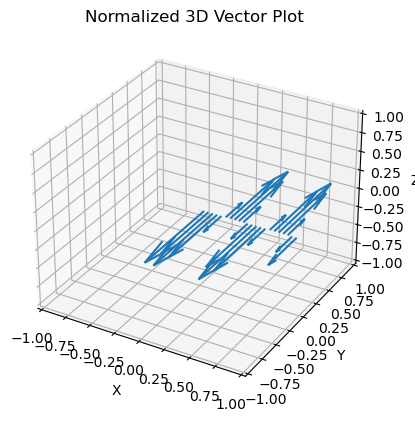

In [17]:
plot_3d_vectors(Hs[-1, ::10, :])

In [16]:
Es[-1, ::10, :]

tensor([[ 0.0000e+00,  0.0000e+00, -2.7814e-06],
        [ 0.0000e+00,  0.0000e+00, -1.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -8.0371e-01],
        [ 0.0000e+00,  0.0000e+00,  9.9974e-01],
        [ 0.0000e+00,  0.0000e+00,  8.2214e-01],
        [ 0.0000e+00,  0.0000e+00,  3.3063e-01],
        [ 0.0000e+00,  0.0000e+00, -2.8735e-01],
        [ 0.0000e+00,  0.0000e+00, -7.9530e-01],
        [ 0.0000e+00,  0.0000e+00, -9.9980e-01],
        [ 0.0000e+00,  0.0000e+00, -8.2217e-01],
        [ 0.0000e+00,  0.0000e+00, -3.3122e-01],
        [ 0.0000e+00,  0.0000e+00,  2.8654e-01],
        [ 0.0000e+00,  0.0000e+00,  7.9498e-01],
        [ 0.0000e+00,  0.0000e+00,  9.9960e-01],
        [ 0.0000e+00,  0.0000e+00,  8.2213e-01],
        [ 0.0000e+00,  0.0000e+00,  3.3075e-01],
        [ 0.0000e+00,  0.0000e+00, -2.8599e-01],
        [ 0.0000e+00,  0.0000e+00, -7.9522e-01],
        [ 0.0000e+00,  0.0000e+00, -9.9905e-01],
        [ 0.0000e+00,  0.0000e+00, -8.2361e-01],
        [ 0.0000e+00